In [1]:
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco_new")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

import jax.numpy as jnp
from jax.scipy import optimize
import jax
jax.config.update("jax_enable_x64", True)
import optimistix as optx
import quadax

from jax.scipy.special import gammaincc, erf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lib.network import get_network_eval_fn
from lib.trafos import transform_network_outputs, transform_network_inputs
from lib.plotting import adjust_plot_1d

from dom_track_eval import get_eval_network_doms_and_track

In [2]:
eval_network = get_network_eval_fn(bpath='/home/storage/hans/jax_reco_new/data/network')

In [3]:
from lib.cgamma_biweight_log_mpe_prob import c_multi_gamma_biweight_mpe_logprob
from lib.cgamma_biweight import c_multi_gamma_biweight_prob, c_multi_gamma_biweight_cdf


In [4]:
convolved_mpe_biweight_v1d_x = jax.jit(jax.vmap(c_multi_gamma_biweight_mpe_logprob, (0, None, None, None, None, None), 0))

In [74]:
from jax.scipy.stats.norm import pdf as norm_pdf

def postjitter_c_mpe_biweight(x, mix_probs, a, b, n, sigma=3.0, sigma_post=2.0):
    nmax = 6.0
    nint1 = 4
    nint2 = 8
    eps = 1.e-6
    x0 = -sigma * 3.0 # start of support of MPE convolved biweight
    
    xmax = jnp.max(jnp.array([x0 + jnp.array(nmax * sigma_post), x + nmax * sigma_post]))
    diff = xmax-x
    xmin = jnp.max(jnp.array([jnp.array(x0)+eps, x - diff]))

    mid_p = xmin + 0.2 * (xmax-xmin)
    xvals = jnp.concatenate([jnp.linspace(xmin, mid_p, nint1), jnp.linspace(mid_p, xmax, nint2)])

    
    dx = xvals[1:] - xvals[:-1]
    xvals = 0.5*(xvals[:-1]+xvals[1:])
    return jnp.sum(norm_pdf(xvals, loc=x, scale=sigma_post) * jnp.exp(convolved_mpe_biweight_v1d_x(xvals, mix_probs, a, b, n, sigma)) * dx)

postjitter_c_mpe_biweight_v1d_x = jax.jit(jax.vmap(postjitter_c_mpe_biweight, (0, None, None, None, None, None, None), 0))

In [103]:
dist = 1
z = -500
rho = 0.0
zenith = np.pi/2
azimuth = 0.0

x = jnp.array([dist, rho, z, zenith, azimuth])
x_prime = transform_network_inputs(x)
y = eval_network(x_prime)
logits, gamma_as, gamma_bs = transform_network_outputs(y)
mix_probs = jax.nn.softmax(logits)

# index 1 is main component
g_a = gamma_as
g_b = gamma_bs
sigma = 3

print(gamma_as, gamma_bs)
print(mix_probs)

[1.00041804 1.1685023  1.00001087] [0.04071644 1.58501109 0.00266282]
[0.06830255 0.91147888 0.02021857]


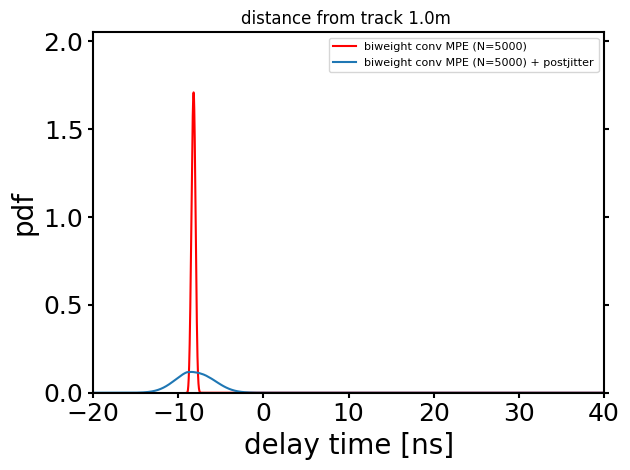

In [105]:
from matplotlib.pyplot import cm

n_p = 5000
fig, ax = plt.subplots()
xvals = np.linspace(-20, 40, 100000)
y_max = 0

ys = jnp.exp(convolved_mpe_biweight_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0)))
plt.plot(xvals, ys, label=f'biweight conv MPE (N={n_p:.0f})', color='red', linestyle='solid')
y_max = np.amax([y_max, np.nanmax(ys)])

ys = postjitter_c_mpe_biweight_v1d_x (xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0), jnp.array(2.0))
plt.plot(xvals, ys, label=f'biweight conv MPE (N={n_p:.0f}) + postjitter', color='tab:blue', linestyle='solid')
y_max = np.amax([y_max, np.nanmax(ys)])

plot_args = {'xlim':[-20, 40],
                     'ylim':[0.0, 1.2*y_max],
                     #'ylim':[0.0, 0.5],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"distance from track {dist:.1f}m ")
plt.tight_layout()
plt.legend(fontsize=8)
plt.show()

In [93]:
dist = 10
z = 500
rho = 0.0
zenith = jnp.pi/2
azimuth = 0.0

x = jnp.array([dist, rho, z, zenith, azimuth])
x_prime = transform_network_inputs(x)
y = eval_network(x_prime)
logits, gamma_as, gamma_bs = transform_network_outputs(y)
mix_probs = jax.nn.softmax(logits)

# index 1 is main component
g_a = gamma_as
g_b = gamma_bs
sigma = 3

print(gamma_as, gamma_bs)

[1.98767923 4.10565841 1.04174722] [0.06666885 0.53280786 0.0056159 ]


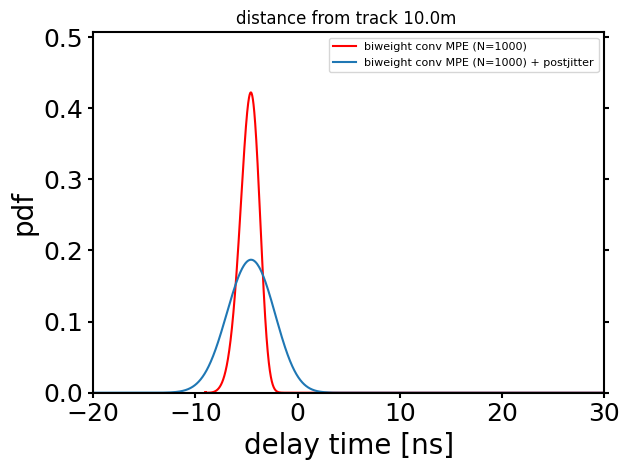

In [94]:
from matplotlib.pyplot import cm

n_p = 1000
fig, ax = plt.subplots()
xvals = np.linspace(-20, 30, 100000)

y_max = 0
ys = jnp.exp(convolved_mpe_biweight_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0)))
plt.plot(xvals, ys, label=f'biweight conv MPE (N={n_p:.0f})', color='red', linestyle='solid')
y_max = np.amax([y_max, np.nanmax(ys)])

ys = postjitter_c_mpe_biweight_v1d_x (xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0), jnp.array(2.0))
plt.plot(xvals, ys, label=f'biweight conv MPE (N={n_p:.0f}) + postjitter', color='tab:blue', linestyle='solid')
y_max = np.amax([y_max, np.nanmax(ys)])


plot_args = {'xlim':[-20, 30],
                     'ylim':[0.0, 1.2*y_max],
                     #'ylim':[0.0, 0.5],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"distance from track {dist:.1f}m ")
plt.tight_layout()
plt.legend(fontsize=8)
plt.show()

In [47]:
dist = 50
z = -500
rho = 0.0
zenith = np.pi/2
azimuth = 0.0

x = jnp.array([dist, rho, z, zenith, azimuth])
x_prime = transform_network_inputs(x)
y = eval_network(x_prime)
logits, gamma_as, gamma_bs = transform_network_outputs(y)
mix_probs = jax.nn.softmax(logits)

# index 1 is main component
g_a = gamma_as
g_b = gamma_bs
sigma = 3

print(gamma_as, gamma_bs)

[2.73125577 5.07845312 1.42588022] [0.01738148 0.09826254 0.00199056]


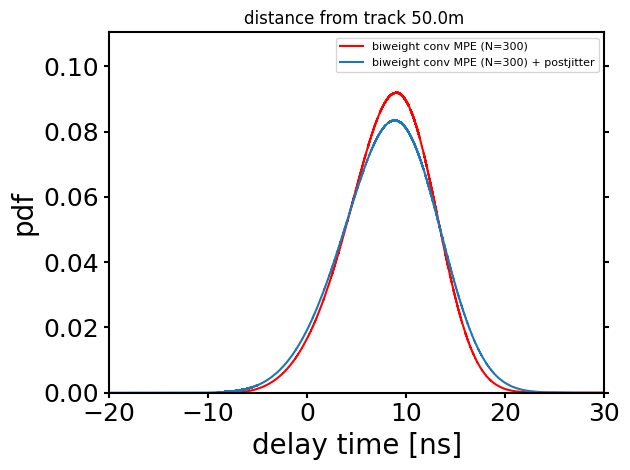

In [48]:
from matplotlib.pyplot import cm

n_p = 300
fig, ax = plt.subplots()
xvals = np.linspace(-20, 30, 100000)

y_max = 0
ys = jnp.exp(convolved_mpe_biweight_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0)))
plt.plot(xvals, ys, label=f'biweight conv MPE (N={n_p:.0f})', color='red', linestyle='solid')
y_max = np.amax([y_max, np.nanmax(ys)])

ys = postjitter_c_mpe_biweight_v1d_x (xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0), jnp.array(2.0))
plt.plot(xvals, ys, label=f'biweight conv MPE (N={n_p:.0f}) + postjitter', color='tab:blue', linestyle='solid')
y_max = np.amax([y_max, np.nanmax(ys)])


plot_args = {'xlim':[-20, 30],
                     'ylim':[0.0, 1.2*y_max],
                     #'ylim':[0.0, 0.5],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"distance from track {dist:.1f}m ")
plt.tight_layout()
plt.legend(fontsize=8)
plt.show()